# Day 7 - Classification (kNN & Logistic)

What happens when the outcome is a word instead of number? Let's see how we can use kNN and logistic regression to predict categorical outcomes.

## Load & Prepare Data

In [167]:
# import libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 

import warnings 
warnings.filterwarnings('ignore')

# Read the "encoder_data.csv" dataset and take a quick look
missions_df = pd.read_csv('/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/encoded_data.csv')

# Force the response into a binary indicator:
missions_df['mission_outcome'] = 1*(missions_df['mission_outcome'] == "Success")

print(missions_df.shape)


(425, 17)


## Split the data 

In [168]:
# split into train and validation
mission_train, mission_val = train_test_split(missions_df, train_size = 0.75, random_state = 109)

print(mission_train.shape, mission_val.shape)

(318, 17) (107, 17)


### $k$-NN model fitting
Define and fit a $k$-NN classification model with $k=20$ to predict `mission_outcome` from `mental_health_score`.

In [169]:
# select variables for model estimation: be careful of single or double square brackets)
x_train = mission_train[["mental_health_score"]]
y_train = mission_train["mission_outcome"]

# define the model
knn20 = KNeighborsClassifier(n_neighbors=20)

# fit to the data
knn20.fit(x_train , y_train)

KNeighborsClassifier(n_neighbors=20)

### $k$-NN prediction

Perform some simple predictions: both the pure classifications and the probability estimates.

In [170]:
# there are two types of predictions in classification models in sklearn
# model.predict for pure classifications, and model.predict_proba for probabilities

# create the predictions based on the train data
yhat20_class = knn20.predict(x_train)
yhat20_prob = knn20.predict_proba(x_train)

# print out the first 10 predictions for the actual data
print(yhat20_class[1:10])
print(yhat20_prob[1:10])

[1 1 1 1 1 1 1 1 1]
[[0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.25 0.75]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]
 [0.   1.  ]]


In [171]:
# Create a logistic regression model, with None as the penalty

logit1 = LogisticRegression(penalty=None, max_iter = 1000)

# Fit the model using the training set

logit1.fit(x_train,y_train)

# Get the coefficient estimates

print("Logistic Regression Estimated Betas (B0,B1):",logit1.intercept_,logit1.coef_)



Logistic Regression Estimated Betas (B0,B1): [12.80834208] [[5.10027234]]


In [172]:
# Confirm the probability calculation made above using logit1logit1.predict_proba()
# predict for different observations where mental_health_score = -3, -2, -1, 0, 0.5, 1. 
for x in [-3, -2, -1, 0, 0.5, 1]:
    prob = logit1.predict_proba([[x]])[0][1]
    print(f"Score: {x}, Probability: {prob:.2f}")



Score: -3, Probability: 0.08
Score: -2, Probability: 0.93
Score: -1, Probability: 1.00
Score: 0, Probability: 1.00
Score: 0.5, Probability: 1.00
Score: 1, Probability: 1.00


In [173]:
# Define the equivalent validation variables from `mission_val`

x_val = mission_val[["mental_health_score"]]
y_val = mission_val["mission_outcome"]

# Compute the training & validation accuracy using the estimator.score() function

knn20_train_accuracy = knn20.score(x_train, y_train)
knn20_val_accuracy = knn20.score(x_val, y_val)

logit_train_accuracy = logit1.score(x_train, y_train)
logit_val_accuracy = logit1.score(x_val, y_val)

# Print the accuracies below

print("k-NN Train & Validation Accuracy:", knn20_train_accuracy, knn20_val_accuracy)
print("Logisitic Train & Validation Accuracy:", logit_train_accuracy, logit_val_accuracy)

k-NN Train & Validation Accuracy: 0.9842767295597484 0.9813084112149533
Logisitic Train & Validation Accuracy: 0.9968553459119497 0.9813084112149533


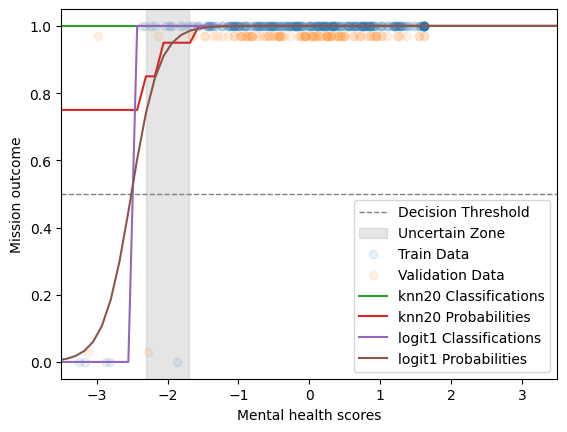

In [174]:

# set-up the dummy x for plotting: we extend it a little bit beyond the range of observed values 
x = np.linspace(np.min( mission_val[["mental_health_score"]].min())-10,(mission_val[["mental_health_score"]].max())+10,200)


# be careful in pulling off only the correct column of the probability calculations: use `[:,1]`
yhat_class_knn20 = knn20.predict(x)
yhat_prob_knn20 = knn20.predict_proba(x)[:,1]

yhat_class_logit = logit1.predict(x)
yhat_prob_logit = logit1.predict_proba(x)[:,1]

# Plot the shaded uncertainty region (probability ≈ 0.5)
# Adjust x-range manually or use inverse-logit approximation around 0.5
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1, label="Decision Threshold")
plt.axvspan(-2.3, -1.7, color='gray', alpha=0.2, label="Uncertain Zone")

# plot the observed data.  Note: we offset the validation points to make them more clearly differentiated from train
plt.plot(x_train, y_train, 'o' ,alpha=0.1, label='Train Data')
plt.plot(x_val, 0.94*y_val+0.03, 'o' ,alpha=0.1, label='Validation Data')

# plot the predictions
plt.plot(x, yhat_class_knn20, label='knn20 Classifications')
plt.plot(x, yhat_prob_knn20, label='knn20 Probabilities')
plt.plot(x, yhat_class_logit, label='logit1 Classifications')
plt.plot(x, yhat_prob_logit, label='logit1 Probabilities')

# adjust the x-axis
plt.legend()
plt.xlim(-3.5,3.5)

# Don't forget axis labels!
plt.xlabel("Mental health scores")
plt.ylabel("Mission outcome")

plt.show()

# Takeaway

This plot shows that missions with low mental health scores are far more likely to fail, while those with higher scores are almost guaranteed to succeed.


- `Logistic Regression`: The brown sigmoid line (logit probabilities) shows a smooth transition: Higher mental health → higher probability of mission success. The purple vertical line shows where the model classifies 0 vs 1 based on a threshold (usually 0.5). Very interpretable.

- `k-NN`: The red kNN curve is bumpy — that's expected. It’s a non-parametric method responding to local data clusters. Compared to logistic regression, it looks less smooth, but that's the nature of the method — it helps highlight model differences